**Isabella Martínez Martínez y Estefanía Laverde Becerra**

# Mini Proyecto 2: Buscaminas Hexagonal
## Inteligencia Artificial: Representación y Solución de Problemas

## Introducción

Para el presente proyecto se plantea la representación en lógica proposicional de una variación del clásico buscaminas: el **buscaminas hexagonal**. En este las casillas son, como su nombre indica, hexágonos, por lo que cada una de estas tiene seis casillas adyacentes. En lo demás, funciona de la misma manera en que lo hace el buscaminas, cuyas reglas en resumen son las siguientes.

- En cada casilla puede haber o no un número que indique la cantidad de minas que hay en las casillas circundantes. Si no posee un número, esto es que ninguna de sus casillas vecinas tiene mina.
- Si se descubre una casilla con mina se pierde la partida.
- Se pueden poner marcas (banderas) en las casillas donde se cree que hay una mina.

El objetivo es despejar todas las casillas que no posean una mina.


## Ambiente

El ambiente fue implementado utilizando principalmente `matplotlib`, así como `numpy` y `random`. Empezamos importando las librerías relevantes para el buen funcionamiento del cuaderno.

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pltS

from time import time
from itertools import combinations

from ambiente import *
from logica import *

Al definir la clase `Buscaminas` se puede establecer su ancho, alto, y número de minas. En caso de no especificarse, se toma por defecto el buscaminas en nivel principiante, esto es, un buscaminas de $8 \times 8$ con $10$ minas.

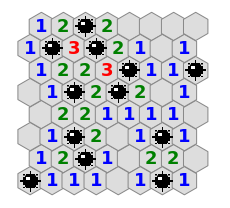

In [ ]:
buscaminas = Buscaminas()
buscaminas.pintar_todo()

El ambiente posee además algunas funciones que permiten jugar de forma manual. Por ejemplo, para verificar el buen funcionamiento del ambiente, se utiliza el método `transicion` para especificar la casilla que se quiere despejar. Note que el conteo se hace como una matriz en donde la esquina inferior izquierda es el origen $(0,0)$.

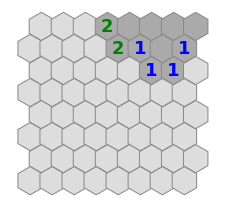

In [ ]:
buscaminas.transicion((7,7))
buscaminas.pintar_casilla()

También podemos marcar una casilla donde sabemos que hay una mina.

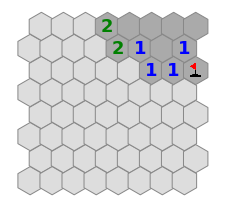

In [ ]:
buscaminas.agregar_quitar_bandera((7,5))
buscaminas.pintar_casilla()

Formalmente, decimos que este problema posee las siguientes características.

| Opción 1 | Opción 2 |
| :---: | :---: |
| Completamente observable | Parcialmente observable $\checkmark$ |
| Agente único $\checkmark$ | Multiagente |
| Determinista $\checkmark$ | Estocástico  |
| Episódico    | Secuencial $\checkmark$ |
| Estático $\checkmark$    | Dinámico    |
| Discreto $\checkmark$    | Continuo    |
| Conocido $\checkmark$    | Desconocido

Además, se destacan las siguientes propiedades.

- **Entorno:** una rejilla de hexágonos, de tamaño definido $n \times m$, donde $n$ es el ancho y $m$ el alto, y una cantidad de minas $k$, repartidas de manera aleatoria con probabilidad uniforme en las casillas definidas.

- **Actuadores:** el agente puede escoger `despejar` una casilla si cree que no hay una mina, o por el contrario, `marcar` la casilla con una bandera si cree que tiene una mina.

- **Sensores:** el agente puede saber cuántas minas hay en las casillas circundantes a una casilla en particular al determinar el número que posee esta.

- **Medida de desempeño:** el agente puede o ganar la partida al despejar todas las casillas sin bomba o perderla si despeja una mina o no las marca de forma correcta.

## Planteamiento de reglas proposicionales

Antes de proponer las reglas lógicas que definen el comportamiento del agente, debemos determinar la representación en lógica proposicional que se le va a dar.

**Átomos**

Cada casilla y la información que se posea sobre la misma constituirá un átomo. Es por esto que necesitamos su ubicación dentro de la matriz y el número que esta tenga. Por lo tanto, tendremos una tripleta `(x,y,k)`, siendo `k` el indicativo de su número.

Con esto podemos determinar:

- `P(x,y,0)` es verdadero si la casilla `(x,y)` posee una mina.
- `P(x,y,k)` con $1 \leq k \leq 6$ es verdadero si alrededor de la casilla `(x,y)` hay `k` minas.

Para poder codificar estos átomos mediante un solo caracter se usa un `Descriptor`. Nótese que este se debe definir con base en el tamaño del buscaminas, por lo que depende de cada juego.


In [ ]:
options = [
    'hay 1 mina', 'hay 1 mina alrededor', 'hay 2 minas alrededor',
    'hay 3 minas alrededor', 'hay 4 minas alrededor', 'hay 5 minas alrededor',
    'hay 6 minas alrededor'    
]

In [ ]:
information = Descriptor([buscaminas.width, buscaminas.height, len(options)])

Ahora, se definen las $3$ reglas que utilizaremos para la resolución del buscaminas, y las más sencillas de razonar para un principiante en buscaminas. Primero, es la determinación de si una casilla es segura o no.

Suponga el caso de la casilla $(0,0)$ por simplicidad, y que tenga un $1$. Esto indica que tenemos dos opciones para que esté la mina, que son las adyacentes a esta casilla: $(0,1)$ o $(1,0)$.

¿Cómo sabemos cuál casilla es segura?

Esto se determina si ya sabemos la posición de la mina.

- Si hay un $1$ en $(0,0)$ y hay una mina en $(0,1)$, entonces no hay mina en $(1,0)$.
- Si hay un $1$ en $(0,0)$ y hay una mina en $(1,0)$, entonces no hay mina en $(0,1)$.

Y así sucesivamente para cada adyacente y cada combinación posible definida por el número de minas alrededor de la casilla.

In [ ]:
def casilla_segura(numMinas, width, height, information):
  casillas = [(x,y) for x in range(width) for y in range(height)]
  formulas = []
  for casilla in casillas:
    casAdy = adyacentes(casilla, width, height) 
    x, y = casilla
    for comb in combinations(casAdy,numMinas):
      form = information.P([x,y,numMinas])
      otras = [cas for cas in casAdy if cas not in comb]
      for casComb in comb:
        form += 'Y'+information.P([casComb[0],casComb[1],0])
      for cas in otras:
        formulas.append(form + '>-' + information.P([cas[0],cas[1],0]))

  return formulas

Con un razonamiento análogo se pueden definir también qué casillas tienen una mina. Siguiendo el ejemplo anterior, podemos decir lo siguiente.

- Si hay un $1$ en $(0,0)$ y no hay una mina en $(0,1)$, entonces hay mina en $(1,0)$.
- Si hay un $1$ en $(0,0)$ y no hay una mina en $(1,0)$, entonces hay mina en $(0,1)$.

In [ ]:
def casilla_con_mina(numMinas, width, height, information):
  casillas = [(x,y) for x in range(width) for y in range(height)]
  formulas = []
  for casilla in casillas:
    casAdy = adyacentes(casilla, width,height)
    x, y = casilla 
    for comb in combinations(casAdy,numMinas):
      form = information.P([x,y,numMinas])
      otras = [cas for cas in casAdy if cas not in comb]
      for cas in otras:
        form += 'Y-'+information.P([cas[0],cas[1],0])
      for casComb in comb:
        formulas.append(form + '>' + information.P([casComb[0],casComb[1],0]))

  return formulas

La siguiente regla le indica al agente el hecho de que toda casilla con un número, naturalmente, no tiene una mina.

In [ ]:
def numero_en_casilla(numOptions, width, height, information):
  casillas = [(x,y) for x in range(width) for y in range(height)]
  formulas = []

  for casilla in casillas:
    x, y = casilla
    formulas += [information.P([x,y,i])+'>-'+information.P([x,y,0]) for i in range(1,numOptions)]

  return formulas

Esto se sintetiza en la siguiente función, la cual será la encargada de crear las reglas para incluir en la base de conocimiento.

In [ ]:
def crear_reglas(numOptions, width, height, information):
  reglas = []
  
  for i in range(1,numOptions):
    reglas += casilla_segura(i, width, height, information)
    reglas += casilla_con_mina(i, width, height, information)
  reglas += numero_en_casilla(numOptions, width, height, information)

  return reglas

Con esto, se procede a la creación del `Agente`, al cual se le incluirá en su base de conocimiento las reglas definidas previamente, así como los átomos correspondientes.

In [ ]:
agente = Agente(buscaminas, descriptor = information)
agente.base_conocimiento = LPQuery(crear_reglas(len(options), buscaminas.width, buscaminas.height, information))
atomos = []
for i in range(buscaminas.width):
    for j in range(buscaminas.height):
        for v in range(len(options)):
            atomos.append(information.P([i, j, v]))
            atomos.append('-' + information.P([i, j, v]))
agente.base_conocimiento.atomos = atomos

Como hemos hecho algunos cambios en el buscaminas, le decimos al agente que interprete sus sensores y lo incluya en su base de conocimiento.

In [ ]:
c = agente.make_percept_sentence()
agente.base_conocimiento.TELL(c)

Recordemos el buscaminas que llevamos hasta este momento.

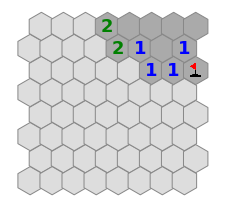

In [ ]:
buscaminas.pintar_casilla()

Podemos probar las reglas implementadas al preguntarle si puede deducir que hay una mina en la casilla $(4,5)$, que debería ser **verdadero**, y si la casilla $(7,4)$ está libre, que también debería ser **verdadero**.

In [ ]:
ASK(agente.cods.P([4,5,0]), agente.base_conocimiento)

True

In [ ]:
ASK('-' + agente.cods.P([7,4,0]), agente.base_conocimiento)

True

## Implementación del juego

Ahora el agente resolverá un juego con las reglas creadas y llevando a cabo el siguiente razonamiento:

- Primero, se debe despejar una casilla de forma manual.
- Posteriormente, se revisa de forma iterativa las casillas adyacentes a las ya despejadas, con el fin de determinar si se sabe que es segura o tiene una mina.
- De no ser posible decidir una de estas dos opciones, se procede a escoger una casilla aleatoriamente para despejar o marcar.

Creamos un buscaminas sencillo de tamaño $5 \times 5$ y con $4$ bombas.

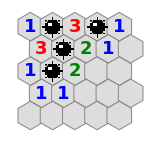

In [ ]:
buscaminas = Buscaminas(5,5,4)
buscaminas.pintar_todo()

Abrimos de forma manual.

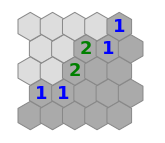

In [ ]:
buscaminas.transicion((0,0))
buscaminas.pintar_casilla()

Se definen descriptores, agente, y se llena la base de conocimiento.

In [ ]:
information = Descriptor([buscaminas.width, buscaminas.height, len(options)])

agente = Agente(buscaminas, descriptor = information)
agente.base_conocimiento = LPQuery(crear_reglas(len(options), buscaminas.width, buscaminas.height, information))
atomos = []
for i in range(buscaminas.width):
    for j in range(buscaminas.height):
        for v in range(len(options)):
            atomos.append(information.P([i, j, v]))
            atomos.append('-' + information.P([i, j, v]))
agente.base_conocimiento.atomos = atomos

c = agente.make_percept_sentence()
agente.base_conocimiento.TELL(c)

Se resuelve el juego.

¡Felicidades! Juego terminado


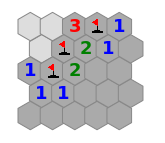

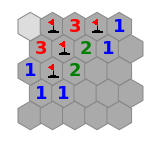

In [ ]:
while buscaminas.juego_activo:

    c = agente.make_percept_sentence()
    agente.base_conocimiento.TELL(c)
    bomba = False
    bombant = False

    if len(buscaminas.casillas_adyacentes_sin_destapar()) != 0:
        for casilla in buscaminas.casillas_adyacentes_sin_destapar():

            if not buscaminas.juego_activo:
                break

            c = agente.make_percept_sentence()
            agente.base_conocimiento.TELL(c)

            x, y = casilla

            obj_bomba = agente.cods.P([x,y,0])
            obj_bombant = '-' + agente.cods.P([x,y,0])

            deducir_bomba = ASK(obj_bomba, agente.base_conocimiento)
            deducir_bombant = ASK(obj_bombant, agente.base_conocimiento)

            if deducir_bomba:
                bomba = True
                buscaminas.agregar_quitar_bandera(casilla)
                
            elif deducir_bombant:
                bombant = True 
                buscaminas.transicion(casilla)

    if buscaminas.juego_activo:
        if bomba == False and bombant == False:
            aleatorio = random.randint(0,2)
            if len(buscaminas.casillas_adyacentes_sin_destapar()) != 0:
                x, y = random.choice(buscaminas.casillas_adyacentes_sin_destapar())
                if aleatorio == 1: buscaminas.transicion((x,y))
                else: buscaminas.agregar_quitar_bandera((x,y))
        buscaminas.pintar_casilla()

Se verifica que el agente marcó correctamente las bombas.

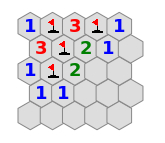

In [ ]:
buscaminas.pintar_todo()

## Comparativa de funcionamiento del agente para distintos tamaños del tablero

Comprobaremos el porcentaje de victorias del agente para distintos tamaños $n \times n$ del buscaminas, es decir, entre $3 \leq n \leq 8$, y aumentando progresivamente a su vez el número de minas. No se contarán las derrotas fruto de abrir erróneamente en el primer movimiento.

In [ ]:
def solve_minesweeper(n):
    if n != 8:
        buscaminas = Buscaminas(n,n, 2*n - 5)
    elif n == 8:
        buscaminas = Buscaminas()

    buscaminas.transicion(random.choice(buscaminas.casillas))

    if not buscaminas.juego_activo:
        if buscaminas.game_won: return 1
        else: return -1

    information = Descriptor([buscaminas.width, buscaminas.height,len(options)])
    agente = Agente(buscaminas, descriptor = information)
    agente.base_conocimiento = LPQuery(crear_reglas(len(options), buscaminas.width, buscaminas.height, information))
    atomos = []
    for i in range(buscaminas.width):
        for j in range(buscaminas.height):
            for v in range(len(options)):
                atomos.append(information.P([i, j, v]))
                atomos.append('-' + information.P([i, j, v]))
    agente.base_conocimiento.atomos = atomos

    while buscaminas.juego_activo:

        c = agente.make_percept_sentence()
        agente.base_conocimiento.TELL(c)
        bomba = False
        bombant = False

        if len(buscaminas.casillas_adyacentes_sin_destapar()) != 0:
            for casilla in buscaminas.casillas_adyacentes_sin_destapar():

                if not buscaminas.juego_activo:
                    break

                c = agente.make_percept_sentence()
                agente.base_conocimiento.TELL(c)

                x, y = casilla

                obj_bomba = agente.cods.P([x,y,0])
                obj_bombant = '-' + agente.cods.P([x,y,0])

                deducir_bomba = ASK(obj_bomba, agente.base_conocimiento)
                deducir_bombant = ASK(obj_bombant, agente.base_conocimiento)

                if deducir_bomba:
                    bomba = True
                    buscaminas.agregar_quitar_bandera(casilla)
                    
                elif deducir_bombant:
                    bombant = True 
                    buscaminas.transicion(casilla)

        else:
            aleatorio = random.randint(0,2)
            x, y = random.choice(buscaminas.casillas)
            if aleatorio == 1: buscaminas.transicion((x,y))
            else: buscaminas.agregar_quitar_bandera((x,y))

        if buscaminas.juego_activo:
            if bomba == False and bombant == False:
                aleatorio = random.randint(0,2)
                if len(buscaminas.casillas_adyacentes_sin_destapar()) != 0:
                    x, y = random.choice(buscaminas.casillas_adyacentes_sin_destapar())
                    if aleatorio == 1: buscaminas.transicion((x,y))
                    else: buscaminas.agregar_quitar_bandera((x,y))

    if buscaminas.game_won: return 1
    else: return 0

Se guardan los tamaños de tableros y porcentajes de victorias para posteriormente crear un _dataframe_.

In [ ]:
sizes = []
percentage_victories = []

for n in range(3,9):
    print('BUSCAMINAS TAMAÑO:',n)
    total = 0
    max_iter = 50
    cont = 0
    while cont < max_iter:
        result = solve_minesweeper(n)
        if result != -1:
            total += result
            cont += 1
    print('\n')
    sizes.append(n)
    percentage_victories.append((total/max_iter)*100)

Con el dataframe creado, se grafican las victorias con respecto al tamaño del tablero de juego.

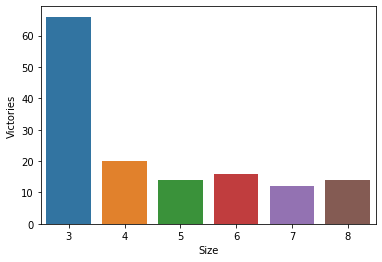

In [ ]:
df_vict = pd.DataFrame(list(zip(sizes, percentage_victories)), columns =['Size', 'Victories'])
sns.barplot(x = 'Size', y = 'Victories', data = df_vict.reset_index())
plt.savefig('victories_plot.pdf') 

Como se puede observar, a medida que el tamaño del juego aumenta, las victorias decrecen. Esto puede deberse a que el agente se va a encontrar frente a más casos en los que es necesario adivinar. 

## Comparativa de tiempos para distintos tamaños del tablero

Análogamente a la anterior comparativa, se itera $50$ veces para cada tamaño $n \times n$ del tablero y se guardan los resultados en un dataframe para ser graficado el resultado.

In [ ]:
sizes = []
times = []
for n in range(3,9):
    print('BUSCAMINAS TAMAÑO:',n)
    max_iter = 50
    cont = 0
    while cont < max_iter:
        arranca  = time()
        result = solve_minesweeper(n)
        para = time()
        if result != -1:
            times.append(para - arranca)
            sizes.append(n)
            cont += 1
    print('\n')

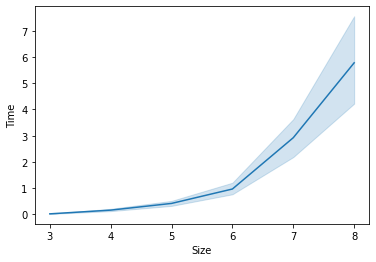

In [ ]:
df_times = pd.DataFrame(list(zip(sizes, times)), columns =['Size', 'Time'])
sns.lineplot(x = 'Size', y = 'Time', data = df_times.reset_index())
plt.savefig('times_plot.pdf')  

Note que naturalmente conforme aumenta el tamaño del problema también aumenta el número de átomos y por ende de reglas del problema, haciendose mayor el tiempo de ejecución en búsqueda del movimiento óptimo. 

**Isabella Martínez Martínez y Estefanía Laverde Becerra**